In [1]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

# 1. 데이터 살펴보기

Campus Recruitment https://www.kaggle.com/datasets/benroshan/factors-affecting-campus-placement

In [4]:
df = pd.read_csv('/content/drive/MyDrive/쿠빅/딥러닝 방학세션/3주차 과제/Placement_Data_Full_Class.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB


ssc_p: Secondary Education percentage- 10th Grade\
ssc_b: Board of Education- Central/ Others\
hsc_p: Higher Secondary Education percentage- 12th Grade\
hsc_b: Board of Education- Central/ Others\
hsc_s: Specialization in Higher Secondary Education\
degree_p: Degree Percentage\
degree_t: Under Graduation(Degree type)- Field of degree education\
workex: Work Experience\
etest_p: Employability test percentage ( conducted by college)\
specialisation: Post Graduation(MBA)- Specialization\
mba_p: MBA percentage\
status: Status of placement- Placed/Not placed\
salary: Salary offered by corporate to candidates

In [6]:
df.describe()

,sl_no,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,148.000000
mean,108.000000,67.303395,66.333163,66.370186,72.100558,62.278186,288655.405405
std,62.209324,10.827205,10.897509,7.358743,13.275956,5.833385,93457.452420
min,1.000000,40.890000,37.000000,50.000000,50.000000,51.210000,200000.000000
25%,54.500000,60.600000,60.900000,61.000000,60.000000,57.945000,240000.000000
50%,108.000000,67.000000,65.000000,66.000000,71.000000,62.000000,265000.000000
75%,161.500000,75.700000,73.000000,72.000000,83.500000,66.255000,300000.000000
max,215.000000,89.400000,97.700000,91.000000,98.000000,77.890000,940000.000000


Gender

In [7]:
df['gender'].value_counts()

M    139
F     76
Name: gender, dtype: int64

In [8]:
df[df['gender']== 'M']['status'].value_counts()/len(df[df['gender']== 'M']['status'])

Placed        0.719424
Not Placed    0.280576
Name: status, dtype: float64

In [9]:
df[df['gender']== 'F']['status'].value_counts()/len(df[df['gender']== 'F']['status'])

Placed        0.631579
Not Placed    0.368421
Name: status, dtype: float64

Board of Education

In [10]:
df['ssc_b'].value_counts()

Central    116
Others      99
Name: ssc_b, dtype: int64

In [11]:
df[df['ssc_b']== 'Central']['status'].value_counts()/len(df[df['ssc_b']== 'Central']['status'])

Placed        0.672414
Not Placed    0.327586
Name: status, dtype: float64

In [12]:
df[df['ssc_b']== 'Others']['status'].value_counts()/len(df[df['ssc_b']== 'Others']['status'])

Placed        0.707071
Not Placed    0.292929
Name: status, dtype: float64

Board of Education

In [13]:
df['hsc_b'].value_counts()

Others     131
Central     84
Name: hsc_b, dtype: int64

Specialization in Higher Secondary Education

In [14]:
df['hsc_s'].value_counts()

Commerce    113
Science      91
Arts         11
Name: hsc_s, dtype: int64

 Under Graduation(Degree type)

In [15]:
df['degree_t'].value_counts()

Comm&Mgmt    145
Sci&Tech      59
Others        11
Name: degree_t, dtype: int64

Work experience

In [16]:
df['workex'].value_counts()

No     141
Yes     74
Name: workex, dtype: int64

 Post Graduation(MBA)

In [17]:
df['specialisation'].value_counts()

Mkt&Fin    120
Mkt&HR      95
Name: specialisation, dtype: int64

고용 여부

In [18]:
df['status'].value_counts()

Placed        148
Not Placed     67
Name: status, dtype: int64

# 2. 데이터 전처리

one-hot encoding

In [19]:
df['gender'].replace({'M':1,'F':0},inplace=True)
df['workex'].replace({'No':0,'Yes':1},inplace=True)
df['status'].replace({'Placed':1,'Not Placed':0},inplace=True)
df['ssc_b'].replace({'Others':0,'Central':1},inplace=True)
df['hsc_b'].replace({'Others':0,'Central':1},inplace=True)
df['hsc_s'].replace({'Science':2,'Commerce':1,'Arts':0},inplace=True)
df['degree_t'].replace({'Sci&Tech':0, 'Comm&Mgmt':1, 'Others':2},inplace = True)
df['specialisation'].replace({'Mkt&HR':0,'Mkt&Fin':1},inplace=True)

In [20]:
X= df.drop(['status','salary','sl_no'], axis=1)
y= df['status']

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          215 non-null    int64  
 1   ssc_p           215 non-null    float64
 2   ssc_b           215 non-null    int64  
 3   hsc_p           215 non-null    float64
 4   hsc_b           215 non-null    int64  
 5   hsc_s           215 non-null    int64  
 6   degree_p        215 non-null    float64
 7   degree_t        215 non-null    int64  
 8   workex          215 non-null    int64  
 9   etest_p         215 non-null    float64
 10  specialisation  215 non-null    int64  
 11  mba_p           215 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 20.3 KB


Dataframe -> array

In [22]:
input = np.array(X)
output = np.array(y)

train, test 분리

In [23]:
x_train, x_test, y_train, y_test = train_test_split(input,output, test_size = 0.2, random_state = 42, stratify= output, shuffle = True)

Tensor로 변형

In [24]:
# to(device): GPU로 전송
x_train = torch.FloatTensor(x_train).to(device)  #FloatTensor: 32비트 부동소수점 (Tensor의 default)
y_train = torch.LongTensor(y_train).to(device) #LongTensor: 64비트 정수(부호있음)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

In [25]:
print(x_train[0])
print(x_train[0].size())
print(y_train[0])
#input 속성 12개
#output class 2개 (0과 1 고용과 고용x)

tensor([ 1.0000, 70.0000,  1.0000, 74.0000,  1.0000,  1.0000, 65.0000,  1.0000,
         0.0000, 83.0000,  1.0000, 62.2800])
torch.Size([12])
tensor(1)


사용자 정의 클래스

In [26]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

DataLoader

In [27]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

# 3. 모델 생성 및 구현

## 3.1 모델1 - sigmoid

In [57]:
# sigmoid -> 주로 이진분류할때 쓰임
class Model(torch.nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.layer = nn.Sequential(
        nn.Linear(12,32, bias=True),
        nn.Sigmoid(),
        nn.BatchNorm1d(32),
        nn.Linear(32, 16, bias=True),
        nn.Sigmoid(),
        nn.Linear(16,8, bias=True),
        nn.Sigmoid(),
        nn.Linear(8,2, bias=True),
        nn.Softmax()
    )

  def forward(self,x):
    out = self.layer(x)
    return out

In [58]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [59]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=16, out_features=8, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=8, out_features=2, bias=True)
    (8): Softmax(dim=None)
  )
)

optimizer 설정\
Adam은 SGD + Momentum, RMSprop을 같이 사용하여 더욱 효율적으로 gradient를 조절함

In [60]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

학습

In [61]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 0.7477619051933289
10 0.6177831292152405
20 0.5838873982429504
30 0.5256823301315308
40 0.4658450782299042
50 0.42797577381134033
60 0.4137042164802551
70 0.4051007032394409
80 0.3885428309440613
90 0.38436129689216614


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss

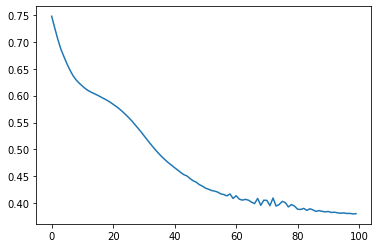

In [62]:
plt.plot(losses)
plt.show()

test accuracy

In [63]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
  
  print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.00565227 0.99434775]
argmax를 한 후의 output은 1
accuracy는 0.7441860465116279


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


## 3.2 모델2 - relu

In [35]:
def relu(x):
  a = torch.zeros_like(x)
  return torch.max(x,a)

In [72]:
class Model(torch.nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Linear(12,32, bias=True)
    self.layer2 = nn.Sequential(
        nn.BatchNorm1d(32),
        nn.Linear(32,16, bias=True)
    )
    self.layer3 = nn.Linear(16,8, bias=True)
    self.layer4 = nn.Sequential(
        nn.Linear(8,2, bias=True),
        nn.Softmax()
    )

# 활성화함수는 forward 메서드에 넣어줘도 무방합니다. 함수형 API를 사용합니다.
  def forward(self,x):
    output = self.layer1(x)
    output = relu(output)

    output = self.layer2(output)
    output = relu(output)

    output = self.layer3(output)
    output = relu(output)
    
    output = self.layer4(output)
    return output

In [73]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Linear(in_features=12, out_features=32, bias=True)
  (layer2): Sequential(
    (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
  )
  (layer3): Linear(in_features=16, out_features=8, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=8, out_features=2, bias=True)
    (1): Softmax(dim=None)
  )
)

In [74]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

In [75]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 0.7401201725006104
10 0.4853239357471466
20 0.4247078597545624
30 0.4042557179927826
40 0.3951943814754486
50 0.3888036906719208
60 0.3888382017612457
70 0.38226574659347534
80 0.3795102536678314
90 0.37818872928619385


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


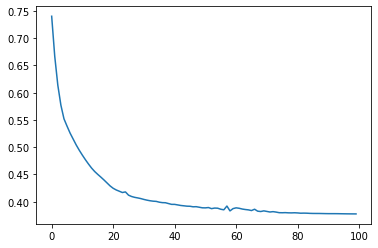

In [76]:
plt.plot(losses)
plt.show()

In [77]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
  
  print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [1.2810672e-06 9.9999869e-01]
argmax를 한 후의 output은 1
accuracy는 0.8372093023255814


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


오잉 이진분류인데 relu가 더 accuracy 좋게 나옴

## 3.3 모델3 - dropout 추가

In [97]:
class Model(torch.nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Linear(12,32, bias=True)
    self.layer2 = nn.Sequential(
        nn.BatchNorm1d(32),
        nn.Linear(32,16, bias=True)
    )
    self.layer3 = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(16,8, bias=True)
    )
    self.layer4 = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(8,2, bias=True),
        nn.Softmax()
    )

# 활성화함수는 forward 메서드에 넣어줘도 무방합니다. 함수형 API를 사용합니다.
  def forward(self,x):
    output = self.layer1(x)
    output = relu(output)

    output = self.layer2(output)
    output = relu(output)

    output = self.layer3(output)
    output = relu(output)
    
    output = self.layer4(output)
    return output

In [98]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Linear(in_features=12, out_features=32, bias=True)
  (layer2): Sequential(
    (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
  )
  (layer3): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=16, out_features=8, bias=True)
  )
  (layer4): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=8, out_features=2, bias=True)
    (2): Softmax(dim=None)
  )
)

In [99]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

In [100]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 0.6930589079856873
10 0.4982176423072815
20 0.4601689279079437
30 0.420181006193161
40 0.4205528199672699
50 0.4011327624320984
60 0.3905124366283417
70 0.3853951394557953
80 0.38871222734451294
90 0.3834552764892578


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


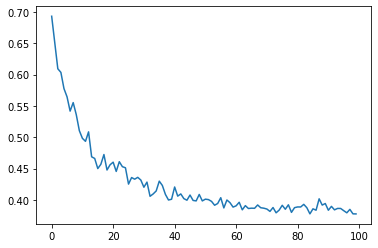

In [101]:
plt.plot(losses)
plt.show()

In [102]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
  
  print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.12353317 0.8764668 ]
argmax를 한 후의 output은 1
accuracy는 0.7906976744186046


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


이미지 데이터가 아니기도 하고 복잡한 데이터가 아니라서 dropout 효과 없는듯